# Считывание файла (Не в pandas)

In [4]:
docs_titles = {}
def one_line(line):
    data = line.split('\t', 1)
    doc_id = int(data[0])
    if len(data[1]) == 1:
        title = ''
    else:
        title = data[1]
    docs_titles[doc_id] = title[:-1] # без \n

In [5]:
with open('data/docs_titles.tsv', 'r') as f:
    l = f.readline()
    for line in f:
        one_line(line)

In [6]:
len(docs_titles)

28026

в качестве предобработки избавимся от:

- верхнего регистра
- не русских и не английских букв и не цифр


- не будем рассматривать the a ... стоп слова
- фильтруем слова по-умному: stemmer (лемматизация хуже)

In [7]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import numpy as np
import re

/home/simon/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [9]:
# import pymorphy2
# morph = pymorphy2.MorphAnalyzer()

In [8]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/simon/snap/jupyter/6/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stop_words = set(stopwords.words(["russian", "english"]))
stemmerR = SnowballStemmer("russian")
stemmerE = SnowballStemmer("english")

In [10]:
titles_data = {}
def title_process(title_id):
    title = docs_titles[title_id].lower()
    tmp = [
#         morph.parse(x.lower())[0].normal_form for x in re.sub('[^0-9a-zа-я]', ' ', title).split()
        stemmerR.stem(stemmerE.stem(x)) for x in re.sub('[^0-9a-zа-я]', ' ', title).split()
        if not x in stop_words
    ]
    titles_data[title_id] = ' '.join([x for x in tmp])

In [11]:
for t in docs_titles:
    title_process(t)

In [12]:
# titles_data
len(titles_data)

28026

# Анализ контента страниц 

это нужно сделать параллельно

нужно сохранить распарсенные данные для упрощения работы

... слишком много данных, ощуение что одних заголовков должно хватить

In [15]:
from multiprocessing.dummy import Pool as ThreadPool 
from multiprocessing.dummy import Lock as ThreadLock 
from multiprocessing.dummy import Value as ThreadValue
import functools
import codecs
import pymorphy2
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [ ]:
# !python3 -m pip install pymorphy2

In [ ]:
# обратно в список
# a = pd.read_csv('texts/text_result_plus_stemm.csv')
# doc_to_text={}
# for i in range(1, 28027):
#     doc_to_text[i]=a.txt[i-1]

# Ищу фичи

In [13]:
from sklearn.preprocessing import StandardScaler

Cтандартизацию стоит применять при использование алгоритмов, которые основываются на измерении расстояний, например, k ближайших соседей или метод опорных векторов. Значит применяем

In [36]:
train_data = pd.read_csv('data/train_groups.csv')
# пререгоняем в словарь
#  по группам
traingroups = {}
for i in range(len(train_data)):
    tmp = train_data.iloc[i]
    doc_group = tmp['group_id']
    doc_id = tmp['doc_id']
    doc_target = tmp['target']
    title = titles_data[doc_id]
    if doc_group not in traingroups:
        traingroups[doc_group] = []
    traingroups[doc_group].append((doc_id, title, doc_target))

X_train = []
y_train = []
groups_train = []

# общие слова
for grp in traingroups:
    docs = traingroups[grp] #  все тексты из группы
    for k, (doc_id, title, doc_target) in enumerate(docs):
        y_train.append(doc_target)
        groups_train.append(grp)
        words = set(title.strip().split())
        common = []
        for j in range(len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, doc_target_j = docs[j]
            words_j = set(title_j.strip().split())
            common.append(len(words.intersection(words_j)))
        X_train.append(sorted(common)[0:20])

In [37]:
X_train = np.array(X_train)
y_train = np.array(y_train)
traingroups = np.array(groups_train)
print (X_train.shape, y_train.shape, traingroups.shape)


(11690, 20) (11690,) (11690,)


так же делаем и для тестовой выборки 

In [38]:
test_data = pd.read_csv('data/test_groups.csv')
testgroups = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = titles_data[doc_id]
    if doc_group not in testgroups:
        testgroups[doc_group] = []
    testgroups[doc_group].append((doc_id, title))
    
X_test = []
groups_test = []
for grp in testgroups:
    docs = testgroups[grp]
    for k, (doc_id, title) in enumerate(docs):
        groups_train.append(grp)
        words = set(title.strip().split())
        common = []
        for j in range(len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            common.append(len(words.intersection(words_j)))
        X_test.append(sorted(common)[:20])

In [39]:
X_test = np.array(X_test)
testgroups = np.array(groups_test)
print (X_test.shape, testgroups.shape)

(16627, 20) (0,)


In [40]:
scale_features_std = StandardScaler()
X_train=scale_features_std.fit_transform(X_train)
X_test=scale_features_std.fit_transform(X_test)
print(X_train.shape, X_test.shape)

(11690, 20) (16627, 20)


### Попробуем что то еще

knn) 
- tfidf хорошо себя зарекомендовал в 1 дз
- так же как и cos метрика
- для метрики используем стандартизатор, так как на нормализаторе валидация хуже 
- исходя из описания проекта BDSCAN должен хорошо себя проявить, что и подтвердилось на практике

tree) 
- для деревъев себя лучше проявляет нормализатор


svc)
- тут опять же используется стандартизатор

In [17]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import Normalizer

In [18]:
class container(object):
    """
    Выделение логики счиывания из файла и предобработки
    """
    def __init__(self, titles, features):
        vec = TfidfVectorizer()
        titles[0] = '' #  нулевого нет
        self.doc_tfidf = vec.fit_transform([titles[i] for i in range(len(titles))])
        tmp = {}
        for i in titles.keys():
            tmp[i] = titles[i].split(' ')
        self.doc = tmp
        self.n_features = features
        self.metric = self.cosine
            
    def cosine(self, group):
        n = self.n_features //2
        X = np.ones(shape=(group.size, self.n_features), dtype=np.float)
        for i, title in enumerate(pairwise_distances(self.doc_tfidf[group], metric='cosine')):
            X[i, :n] = sorted(title)[1:n+1]
        X[:, n:] = np.mean(X[:, :n], axis=0)
        return X
    
    def read(self, file, dbsc_eps=0.5, dbsc_min_samples=5):
        data = pd.read_csv(file)
        groups = data.groupby('group_id')
        if 'target' in data.columns:
            X = np.zeros(shape=(data.shape[0], self.n_features+1), dtype=np.float)
            y = np.zeros(shape=(data.shape[0], ), dtype=bool)
            group_ids = np.zeros(shape=(data.shape[0], ), dtype=int)
            i = 0
            for group_id, group_index in groups.groups.items():
                j = i + group_index.size # выделяю группу
                group = data.iloc[group_index]
                group_ids[i:j] = group_id
                clf = DBSCAN(eps=dbsc_eps, metric="cosine", min_samples=dbsc_min_samples) # крут
                res = clf.fit_predict(self.doc_tfidf[group.doc_id])
                for t in range(len(res)):
                    if res[t] == -1:
                        res[t] = 0
                    else:
                        res[t] = 1
                y[i:j] = group.target
                X[i:j,:-1] = self.metric(group.doc_id)
                X[i:j,-1] = res
#                 X[i:j,-1] = group.target # переобучение :) 
                i = j
            return X, y, group_ids
        else:
            X = np.zeros(shape=(data.shape[0], self.n_features+1), dtype=np.float)
            pair_ids = np.zeros(shape=(data.shape[0], ), dtype=int)
            i = 0
            for group_id, group_index in groups.groups.items():
                j = i + group_index.size
                group = data.iloc[group_index]
                pair_ids[i:j] = group.pair_id
                clf = DBSCAN(0.5, metric="cosine", min_samples=8)
                res = clf.fit_predict(self.doc_tfidf[group.doc_id])
                for t in range(len(res)):
                    if res[t] == -1:
                        res[t] = 0
                    else:
                        res[t] = 1
                X[i:j,:-1] = self.metric(group.doc_id)
                X[i:j,-1] = res
                i = j
            return X, pair_ids
    def predict_knn(X):
        pass

In [19]:
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score

# import warnings
# warnings.filterwarnings("ignore")

In [24]:
def cross_val_knn():
    cos_f = range(4,16,2)
    dbscan_f = [0, 1]
    fech = [0] #  [0, 4, 10]
    nebrs = [25] #  range(5, 30, 5)
    f1 = []
    for c_f in tqdm(cos_f):
        for db_f in dbscan_f:
            for f in fech:
                c = container(titles_data, c_f)
                X, y, groups_train = c.read('data/train_groups.csv')
                scaler = StandardScaler()
                scaler.fit(X[:, :c_f])
                if db_f==1:
                    lft = scaler.transform(X[:,:c_f])
                    X = np.hstack((lft, X[:,c_f][:,np.newaxis]))
                else:
                    X = scaler.transform(X[:,:c_f])
#                 X = np.hstack((X, X_train[:, :f]))
                for n in nebrs:
                    model = KNeighborsClassifier(n)
                    f1.append([cross_val_score(model, X, y, cv=10,scoring = 'f1', n_jobs=-1).mean(),c_f, db_f, f, X.shape, n])
    return f1
                    
f = cross_val_knn()

100%|██████████| 6/6 [00:46<00:00,  7.80s/it]


In [41]:
# X_train

array([[-0.12765977, -0.1722097 , -0.19568812, ..., -0.46330887,
        -0.468977  , -0.47707079],
       [-0.12765977, -0.1722097 , -0.19568812, ..., -0.46330887,
        -0.468977  , -0.47707079],
       [-0.12765977, -0.1722097 , -0.19568812, ..., -0.46330887,
        -0.468977  , -0.47707079],
       ...,
       [-0.12765977, -0.1722097 , -0.19568812, ..., -0.46330887,
        -0.468977  , -0.47707079],
       [-0.12765977, -0.1722097 , -0.19568812, ..., -0.46330887,
        -0.468977  , -0.47707079],
       [-0.12765977, -0.1722097 , -0.19568812, ..., -0.46330887,
        -0.468977  , -0.47707079]])

In [25]:
# score, c_f, db_f, f, X.shape, n
max(f,key=lambda x: x[0])

[0.7440610484465489, 8, 0, 0, (11690, 8), 25]

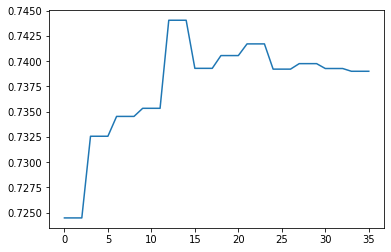

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.set_title("Значение f1 меры для knn различных параметров валидации")
ax1.set_ylabel("f1")
ax1.plot([x[0] for x in f])

In [32]:
# [x[0] for x in f]

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
model = 0
X = 0
y = 0
def cross_val_randomfor():
    c_f = 10
    min_samples_s = [ 4, 5]
    min_samples_l = [ 4, 5]
    n_esti = range(60, 80, 10)
    dbscan_f = [0, 1]
    db_f = 0
    f = 10
    fech = [4, 5]
    crit = ['gini'] #range(5, 30, 5)
    f1 = []
    for ss in tqdm(min_samples_s):
        for sl in min_samples_l:
            for cr in crit:
                c = container(titles_data, c_f)
                X, y, groups_train = c.read('data/train_groups.csv')
                scaler = Normalizer()
                scaler.fit(X[:, :c_f])
                if db_f==1:
                    lft = scaler.transform(X[:,:c_f])
                    X = np.hstack((lft, X[:,c_f][:,np.newaxis]))
                else:
                    X = scaler.transform(X[:,:c_f])
                X = np.hstack((X, X_train[:,:f])) #  тут улучшило
                for n in n_esti:
                    model = RandomForestClassifier(n_estimators=n, criterion=cr, min_samples_split=ss, min_samples_leaf=sl)
                    f1.append([cross_val_score(model, X, y,cv=10,scoring = 'f1').mean(),cr, ss, sl, X.shape, n])
    return f1
                    
f = cross_val_randomfor()

100%|██████████| 2/2 [01:24<00:00, 42.15s/it]


In [48]:
max(f,key=lambda x: x[0])

[0.7248484584698065, 'gini', 4, 5, (11690, 20), 70]

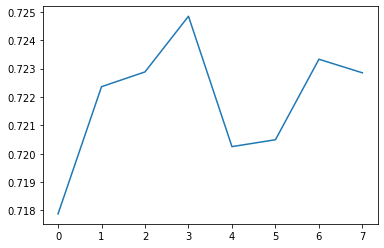

In [49]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title("Значение f1 меры для RandFor различных параметров валидации")
ax1.set_ylabel("f1")

ax1.plot([x[0] for x in f])

In [51]:
from sklearn.svm import SVC

In [52]:
def cross_val_svm():
    c_f = 10
    С_reg = [0.5, 1.0, 2.0]
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
#     min_samples_l = [ 4, 5]
    n_esti = range(60, 80, 10)
    dbscan_f = [0, 1]
    db_f = 0
    f = 10
    fech = [4, 5]
    crit = ['gini'] #range(5, 30, 5)
    f1 = []
    for k in tqdm(kernel):
        for cr in С_reg:
            c = container(titles_data, c_f)
            X, y, groups_train = c.read('data/train_groups.csv')
            scaler = StandardScaler()
            scaler.fit(X[:, :c_f])
            if db_f==1:
                lft = scaler.transform(X[:,:c_f])
                X = np.hstack((lft, X[:,c_f][:,np.newaxis]))
            else:
                X = scaler.transform(X[:,:c_f])
#             X = np.hstack((X, X_train[:,:f]))
            for n in n_esti:
                model = SVC(kernel=k, C=cr)
                f1.append([cross_val_score(model, X, y,cv=10,scoring = 'f1').mean(),k, X.shape, cr])
    return f1
                    
f = cross_val_svm()

100%|██████████| 4/4 [07:50<00:00, 117.71s/it]


In [53]:
max(f,key=lambda x: x[0])

[0.7435096441718135, 'rbf', (11690, 10), 2.0]

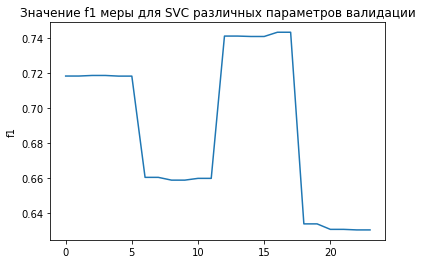

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title("Значение f1 меры для SVC различных параметров валидации")
ax1.set_ylabel("f1")

ax1.plot([x[0] for x in f])

# Учимся

...

In [55]:
c_f = 10
n = 25
f = 10 #fech а надо ли?
c = container(titles_data, c_f)
X_tr, y_tr, groups_tr = c.read('data/train_groups.csv')
scaler = StandardScaler()
scaler.fit(X_tr[:, :c_f])
X_tr = scaler.transform(X_tr[:,:c_f])
model = KNeighborsClassifier(n)
model.fit(X_tr, y_tr)

KNeighborsClassifier(n_neighbors=25)

In [56]:
X_tr.shape

(11690, 10)

In [57]:
c = container(titles_data, c_f)
X_te, pair_ids = c.read('data/test_groups.csv')
scaler = StandardScaler()
scaler.fit(X_te[:, :c_f])
X_te = scaler.transform(X_te[:, :c_f])
# X_te = np.hstack((X_te, X_test[:,:f]))

In [58]:
X_te.shape

(16627, 10)

In [59]:
predict = model.predict(X_te)

In [61]:
with open('last_predict.csv', 'w') as f:
    print('pair_id', 'target', file=f, sep=',')
    for pair_id, target in zip(pair_ids, predict):
        print(pair_id, int(target), sep=',', file=f)

## Еще хотелось бы попробовать бустинг и голосование алгоритмов

и может быть что то еще

Напрашивается мысль о том, что правильная предобработка данных влияет на конечый результат больше, чем выбор подходящего алгоритма 